# [WIP] Normalize data

The flow is much bigger then rainfall. It would be worth trying to normalized both series and then try same models on the data.

In [1]:
import datetime
import time
import calendar
import json
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Load project

In [22]:
project_folder = '../../datasets/thorium-medium/'
with open(project_folder + 'project.json', 'r') as file:
    project = json.load(file)
print(json.dumps(project, indent=4))
flow = pd.read_csv(project_folder + 'flow1.csv', parse_dates=['time'])
flow = flow.set_index('time')['flow'].fillna(0)
flow = flow.resample('5T').pad()
rainfall = pd.read_csv(project_folder + 'rainfall1.csv', parse_dates=['time'])
rainfall = rainfall.set_index('time')['rainfall'].fillna(0)
rainfall = rainfall.resample('5T').pad()
input_data = pd.concat([flow, rainfall], axis=1).dropna()
input_data = input_data['2015-06-02':'2017-11-09']
print(input_data.head())
print(input_data.tail())

{
    "end-date": "2017-10-01",
    "flows": [
        "flow1"
    ],
    "name": "thorium-medium",
    "rainfalls": [
        "rainfall1"
    ],
    "split-date": "2017-01-01",
    "start-date": "2015-06-02"
}
                           flow  rainfall
time                                     
2015-06-02 00:00:00  100.889999       0.0
2015-06-02 00:05:00   99.839996       0.0
2015-06-02 00:10:00   99.279999       0.0
2015-06-02 00:15:00   98.139999       0.0
2015-06-02 00:20:00   97.110001       0.0
                           flow  rainfall
time                                     
2017-11-09 23:35:00  111.739998       0.0
2017-11-09 23:40:00  110.949997       0.0
2017-11-09 23:45:00  110.519997       0.0
2017-11-09 23:50:00  109.190002       0.0
2017-11-09 23:55:00  107.089996       0.0


## Normalize data

In [23]:
input_data['flow_normalized'] = (input_data.flow - np.mean(input_data.flow)) / np.std(input_data.flow)
input_data['rainfall_normalized'] = (input_data.rainfall - np.mean(input_data.rainfall)) / np.std(input_data.rainfall)

input_data.head()

,flow,rainfall,flow_normalized,rainfall_normalized
time,,,,
2015-06-02 00:00:00,100.889999,0.0,-0.347723,-0.316781
2015-06-02 00:05:00,99.839996,0.0,-0.392125,-0.316781
2015-06-02 00:10:00,99.279999,0.0,-0.415806,-0.316781
2015-06-02 00:15:00,98.139999,0.0,-0.464013,-0.316781
2015-06-02 00:20:00,97.110001,0.0,-0.507569,-0.316781


## Feature extractions

In [30]:
# Process time
input_data['minutes_of_day'] = input_data.index.map(lambda x: x.hour*60+x.minute)
input_data['hour'] = input_data.index.map(lambda x: x.hour)

# Process rainfall
rolling_rain = input_data.rainfall_normalized.rolling(12).mean()
for i in range(6):
    key = 'rain_{}h'.format(i+1)
    input_data[key] = rolling_rain.shift(i*288)

input_data = input_data.dropna()
input_x = input_data[['minutes_of_day'] + ['rain_{}h'.format(i+1) for i in range(6)]]
input_y = input_data.flow_normalized
print(input_x.head())
print(input_y.head())

                     minutes_of_day   rain_1h   rain_2h   rain_3h   rain_4h  \
time                                                                          
2015-06-22 03:40:00             220 -0.316781 -0.316781 -0.316781 -0.316781   
2015-06-22 03:45:00             225 -0.316781 -0.316781 -0.316781 -0.316781   
2015-06-22 03:50:00             230 -0.316781 -0.316781 -0.316781 -0.316781   
2015-06-22 03:55:00             235 -0.316781 -0.316781 -0.316781 -0.316781   
2015-06-22 04:00:00             240 -0.316781 -0.316781 -0.316781 -0.316781   

                      rain_5h   rain_6h  
time                                     
2015-06-22 03:40:00 -0.316781 -0.316781  
2015-06-22 03:45:00 -0.316781 -0.316781  
2015-06-22 03:50:00 -0.316781 -0.316781  
2015-06-22 03:55:00 -0.316781 -0.316781  
2015-06-22 04:00:00 -0.316781 -0.316781  
time
2015-06-22 03:40:00   -1.477221
2015-06-22 03:45:00   -1.481449
2015-06-22 03:50:00   -1.482295
2015-06-22 03:55:00   -1.468340
2015-06-22 04:00:00

## Helper functions

Helper functions for building training and test sets and calculating score

## Calculate score

In [36]:
class PredictionModel:
    """Mean model as a reference baseline"""
    
    def fit(self, X, y):
        self.mean = np.mean(y)
        
    def predict(self, X):
        return np.ones(X.shape[0]) * self.mean
    
    
def loss(y_hat, y):
    """
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    """
    return 100.0 * np.sum(np.abs((y-y_hat) / y)) / y.shape[0]


def split_data(split_day):
    """Get all data up to given day"""
    end_day = split_day - pd.Timedelta('1 min')
    next_day = split_day + pd.Timedelta(1, 'D')
    train_x = input_x[:end_day]
    train_y = input_y[:end_day]
    test_x = input_x[next_day: next_day+pd.Timedelta('1439 min')]
    test_y = input_y[next_day: next_day+pd.Timedelta('1439 min')]
    return train_x.values, train_y.values, test_x.values, test_y.values


def evaluate_day(model, split_day):
    """Evaluate data for single day"""
    train_x, train_y, test_x, test_y = split_data(split_day)
    model.fit(train_x, train_y)
    y_hat = model.predict(test_x)
    return loss(y_hat, test_y)


def evaluate_model(model, flow, rain, start_day):
    """
    Evaluate model on all days starting from split_day.
    Returns 90th percentile error as model score
    """
    last_day = flow.index[-1] - pd.Timedelta(1, 'D')
    split_day = start_day
    costs = []
    while split_day < last_day:
        cost = evaluate_day(model, flow, rain, split_day)
        costs.append(cost)
        split_day += pd.Timedelta(1, 'D')
    return np.percentile(costs, 95), costs


score = evaluate_day(PredictionModel(), pd.Timestamp('2017-01-01'))
print('MeanModel score: {:.2f}% (expected: 22.69%)'.format(score))

MeanModel score: 100.00% (expected: 22.69%)


## Plot prediction

In [ ]:
def plot_prediction(model, day, show_rain=True):
    rcParams['figure.figsize'] = 12, 8
    ts = pd.Timestamp(day)
    pred = model.predict(ts, flow, rainfall)
    if show_rain:
        rcParams['figure.figsize'] = 12, 8
        fig = plt.figure()
        ax = plt.subplot(211)
        ax.plot(rainfall[ts: ts+pd.Timedelta('1439 min')].values, label='Rainfall')
        plt.title(day)
        ax = plt.subplot(212)
        ax.plot(pred, label='Prediction')
        ax.plot(flow[ts: ts+pd.Timedelta('1439 min')].values, label='Flow')
    else: 
        rcParams['figure.figsize'] = 12, 4
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.title(day)
        ax.plot(pred, label='Prediction')
        ax.plot(flow[ts: ts+pd.Timedelta('1439 min')].values, label='Flow')
    ax.legend()
    plt.show()

# Models

## Decision Tree Regressor

First not linear model. Should improve on linear model. 
Decision Tree is good for categorical data. So here we should expect better looking prediction

DTModel 2h score: 18.73%
Feature importance: [0.67148804 0.08777938 0.04429962 0.01752262 0.01535025 0.03888955
 0.0284648  0.01110055 0.01167522 0.01709792 0.00789358 0.02563109
 0.02280738]
Calculated in 824.327 seconds


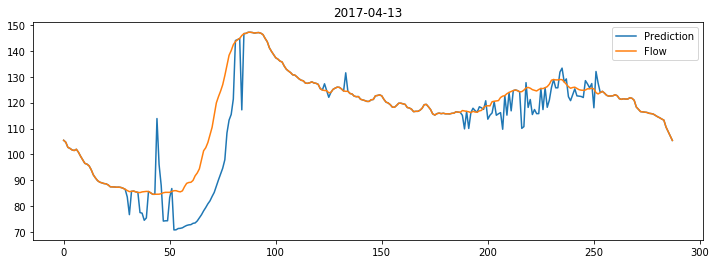

In [28]:
from sklearn import tree

class DTModel:
    
    def __init__(self):
        self.clf = tree.DecisionTreeRegressor()
        
    def fit(self, flow, rain):
        X, y = encode_features(flow, rain)
        self.clf.fit(X.values, y.values)
        
    def predict(self, day, rain, flow):
        X = prepare_prediction_features(day, flow, rain)
        return self.clf.predict(X.values)    

    
start_time = time.time()
dt_model = DTModel()
score, costs = evaluate_model(dt_model, flow_rain.flow, flow_rain.rainfall, pd.Timestamp('2017-01-01'))
print('DTModel 2h score: {:.2f}%'.format(score))
print('Feature importance: {}'.format(dt_model.clf.feature_importances_))
print("Calculated in {:.3f} seconds".format(time.time() - start_time))
plot_prediction(dt_model, '2017-04-13', show_rain=False)

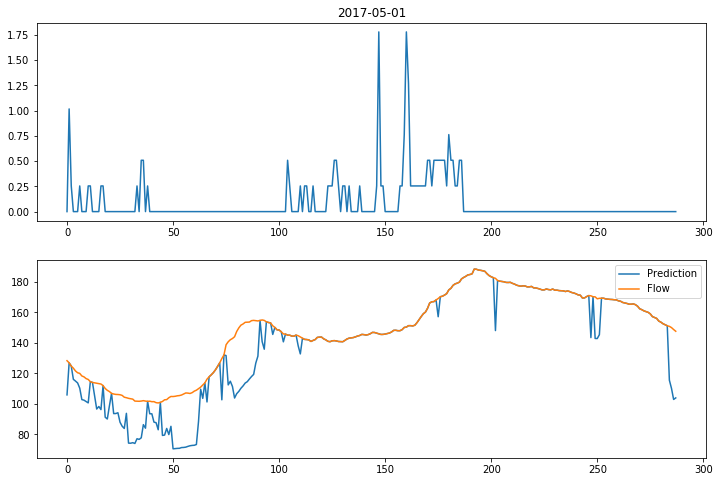

In [34]:
plot_prediction(dt_model, '2017-05-01')

The **dt_model** was already trained on 2017-05-01 and it looks that it just memorises data.
(At least some points)

Lets check how it would loook like if we train the model only on historical data.

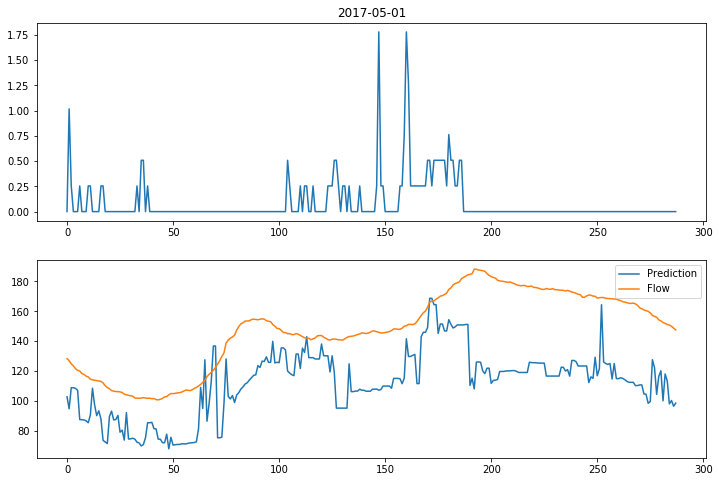

In [36]:
model = DTModel()
evaluate_day(model, flow, rainfall, pd.Timestamp('2017-05-01'))
plot_prediction(model, '2017-05-01')

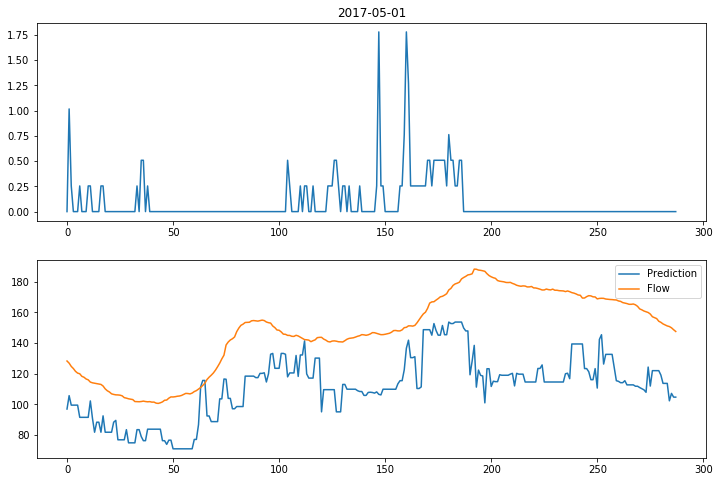

In [40]:
model = DTModelHour()
evaluate_day(model, flow, rainfall, pd.Timestamp('2017-05-01'))
plot_prediction(model, '2017-05-01')